# Postprocessing

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
#%load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

## Load run + general diagnostics

In [2]:
pwd

'/scratch/na00078/QuickCW/sources_post_processing'

## Load h5 file

In [3]:
with h5py.File('/scratch/na00078/QuickCW_targeted_runs/results/3C66B_UL_numba_outfile.h5', 'r') as f:
    print(list(f.keys()))
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

['T-ladder', 'acc_fraction', 'fisher_diag', 'log_likelihood', 'par_names', 'samples_cold']
(100000000, 8)
(1, 100000000)


## Corner Plots

hamp [4.7443014e-18 1.9121157e-15 3.4678784e-18 ... 1.8469806e-18 1.9157049e-16
 1.1201431e-15]
freq [5.7160598e-08 5.7160598e-08 5.7160598e-08 ... 5.5871581e-08 5.5871581e-08
 5.5871581e-08]
mc [3.0264742e+08 3.0264742e+08 3.0264742e+08 ... 6.8110310e+09 6.8110310e+09
 6.8110310e+09]
Length of logdL 90000000
required values 7.375947 5.7160598e-08 302647420.0 1.1595439e-14
dL min 84.942
dL max 86.658
10**log10_d_L [2.5356592e+04 6.2914242e+01 3.4689598e+04 ... 1.1507735e+07 1.1094905e+05
 1.8974865e+04]
min 10**log10_d_L 0.0058563016
max 10**log10_d_L 23765502.0
d_L_mask [     718      793     2199 ... 89985396 89986396 89987022]
Sample shape (90000000, 9)
Sample length 90000000
Original Sample length 1
dL_mask length 24967
9
[1.935154  1.9366169 1.9344015 ... 1.9361935 1.9376822 1.933774 ]
UL MC [3.0264742e+08 3.0264742e+08 3.0264742e+08 ... 6.4338189e+08 6.4338189e+08
 6.4338189e+08]
UL shape 24967
original 24967


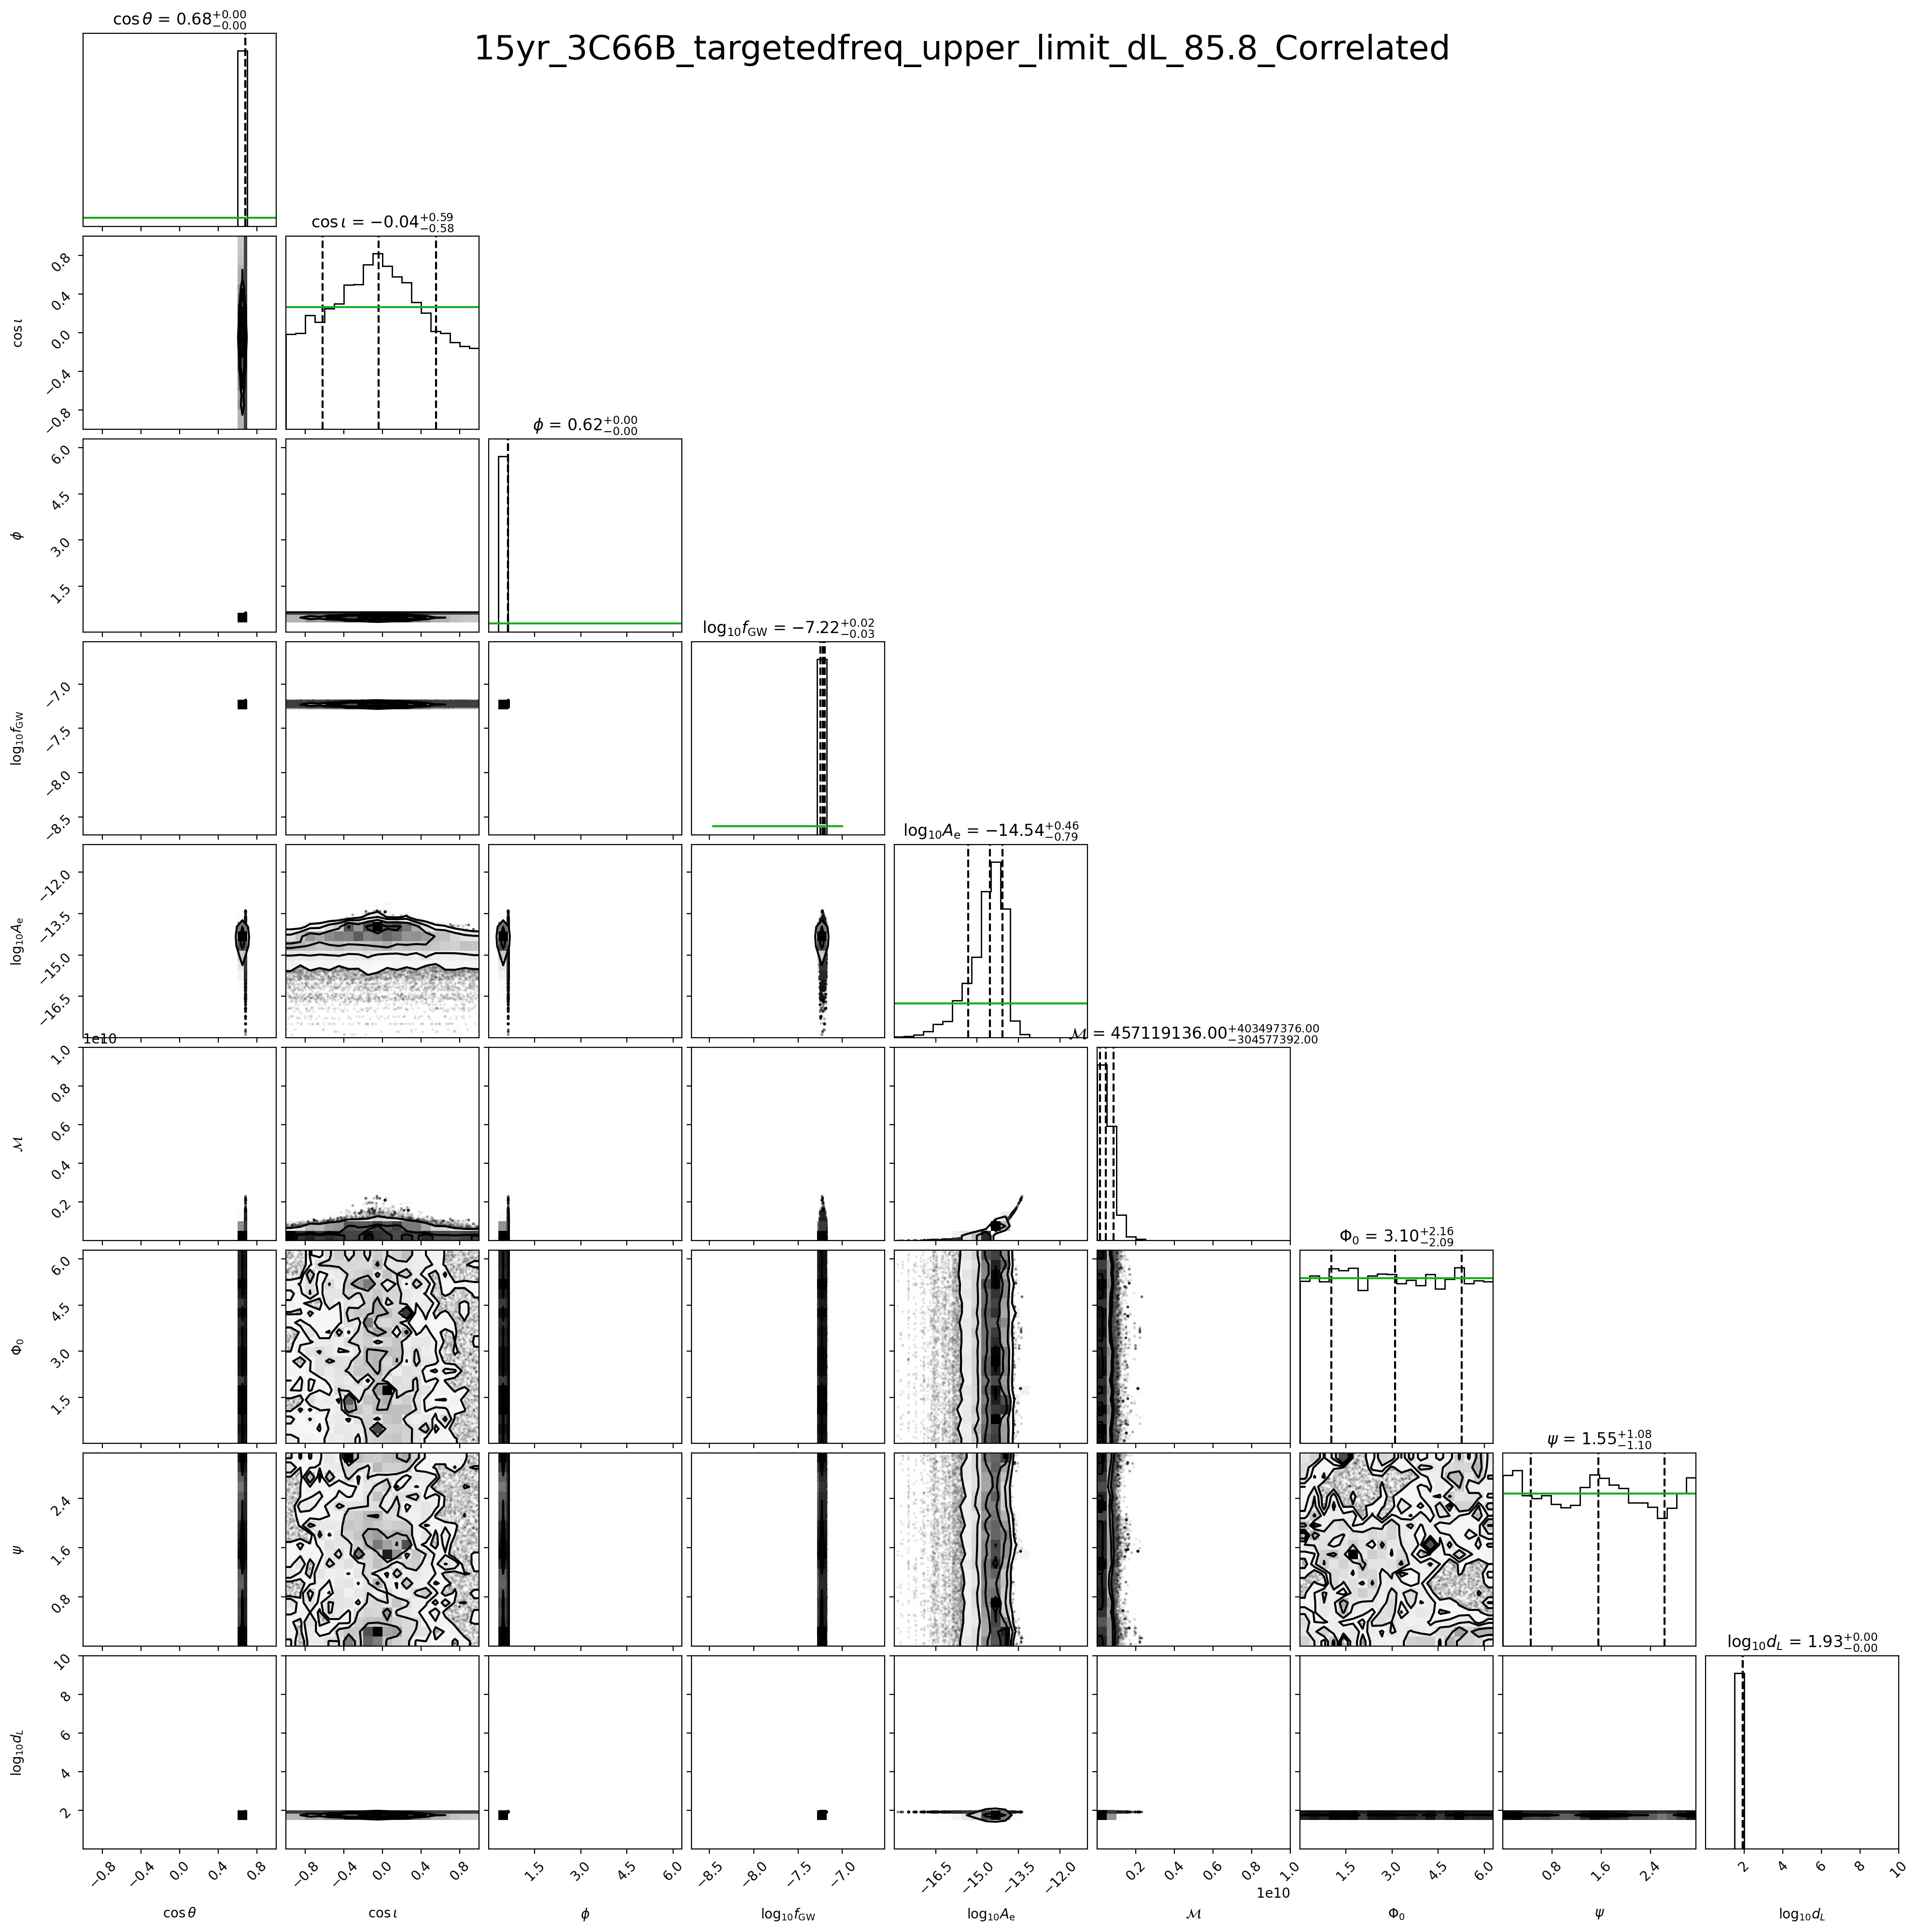

In [4]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"${\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]

#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (10**6.6,10**10), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)


samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("Sample length", len(samples2plot))
print("Original Sample length", len(samples_cold))
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_UL = np.vstack((samples2plot[d_L_mask,0],
                          samples2plot[d_L_mask,1],
                          samples2plot[d_L_mask,2],
                          samples2plot[d_L_mask,3],
                          samples2plot[d_L_mask,4],
                          10**samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7],
                            samples2plot[d_L_mask,8])).T

print(samples2plot[d_L_mask,8])
print("UL MC",10**samples2plot[d_L_mask,5])
print("UL shape",len(samples2plot_UL))
print("original",len(samples2plot[d_L_mask, :]))
fig = corner.corner(samples2plot_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_dL_85.8_Correlated', fontsize = 25);

hamp [4.7443014e-18 1.9121157e-15 3.4678784e-18 ... 1.8469806e-18 1.9157049e-16
 1.1201431e-15]
freq [5.7160598e-08 5.7160598e-08 5.7160598e-08 ... 5.5871581e-08 5.5871581e-08
 5.5871581e-08]
mc [3.0264742e+08 3.0264742e+08 3.0264742e+08 ... 6.8110310e+09 6.8110310e+09
 6.8110310e+09]
Length of logdL 90000000
required values 7.375947e+00 5.7160598e-08 302647420.0 1.1595439e-14
dL min 84.942
dL max 86.658
10**log10_d_L [2.5356592e+04 6.2914242e+01 3.4689598e+04 ... 1.1507735e+07 1.1094905e+05
 1.8974865e+04]
min 10**log10_d_L 0.0058563016
max 10**log10_d_L 23765502.0
d_L_mask [     718      793     2199 ... 89985396 89986396 89987022]
Sample shape (90000000, 9)
dL_mask length 24967
5


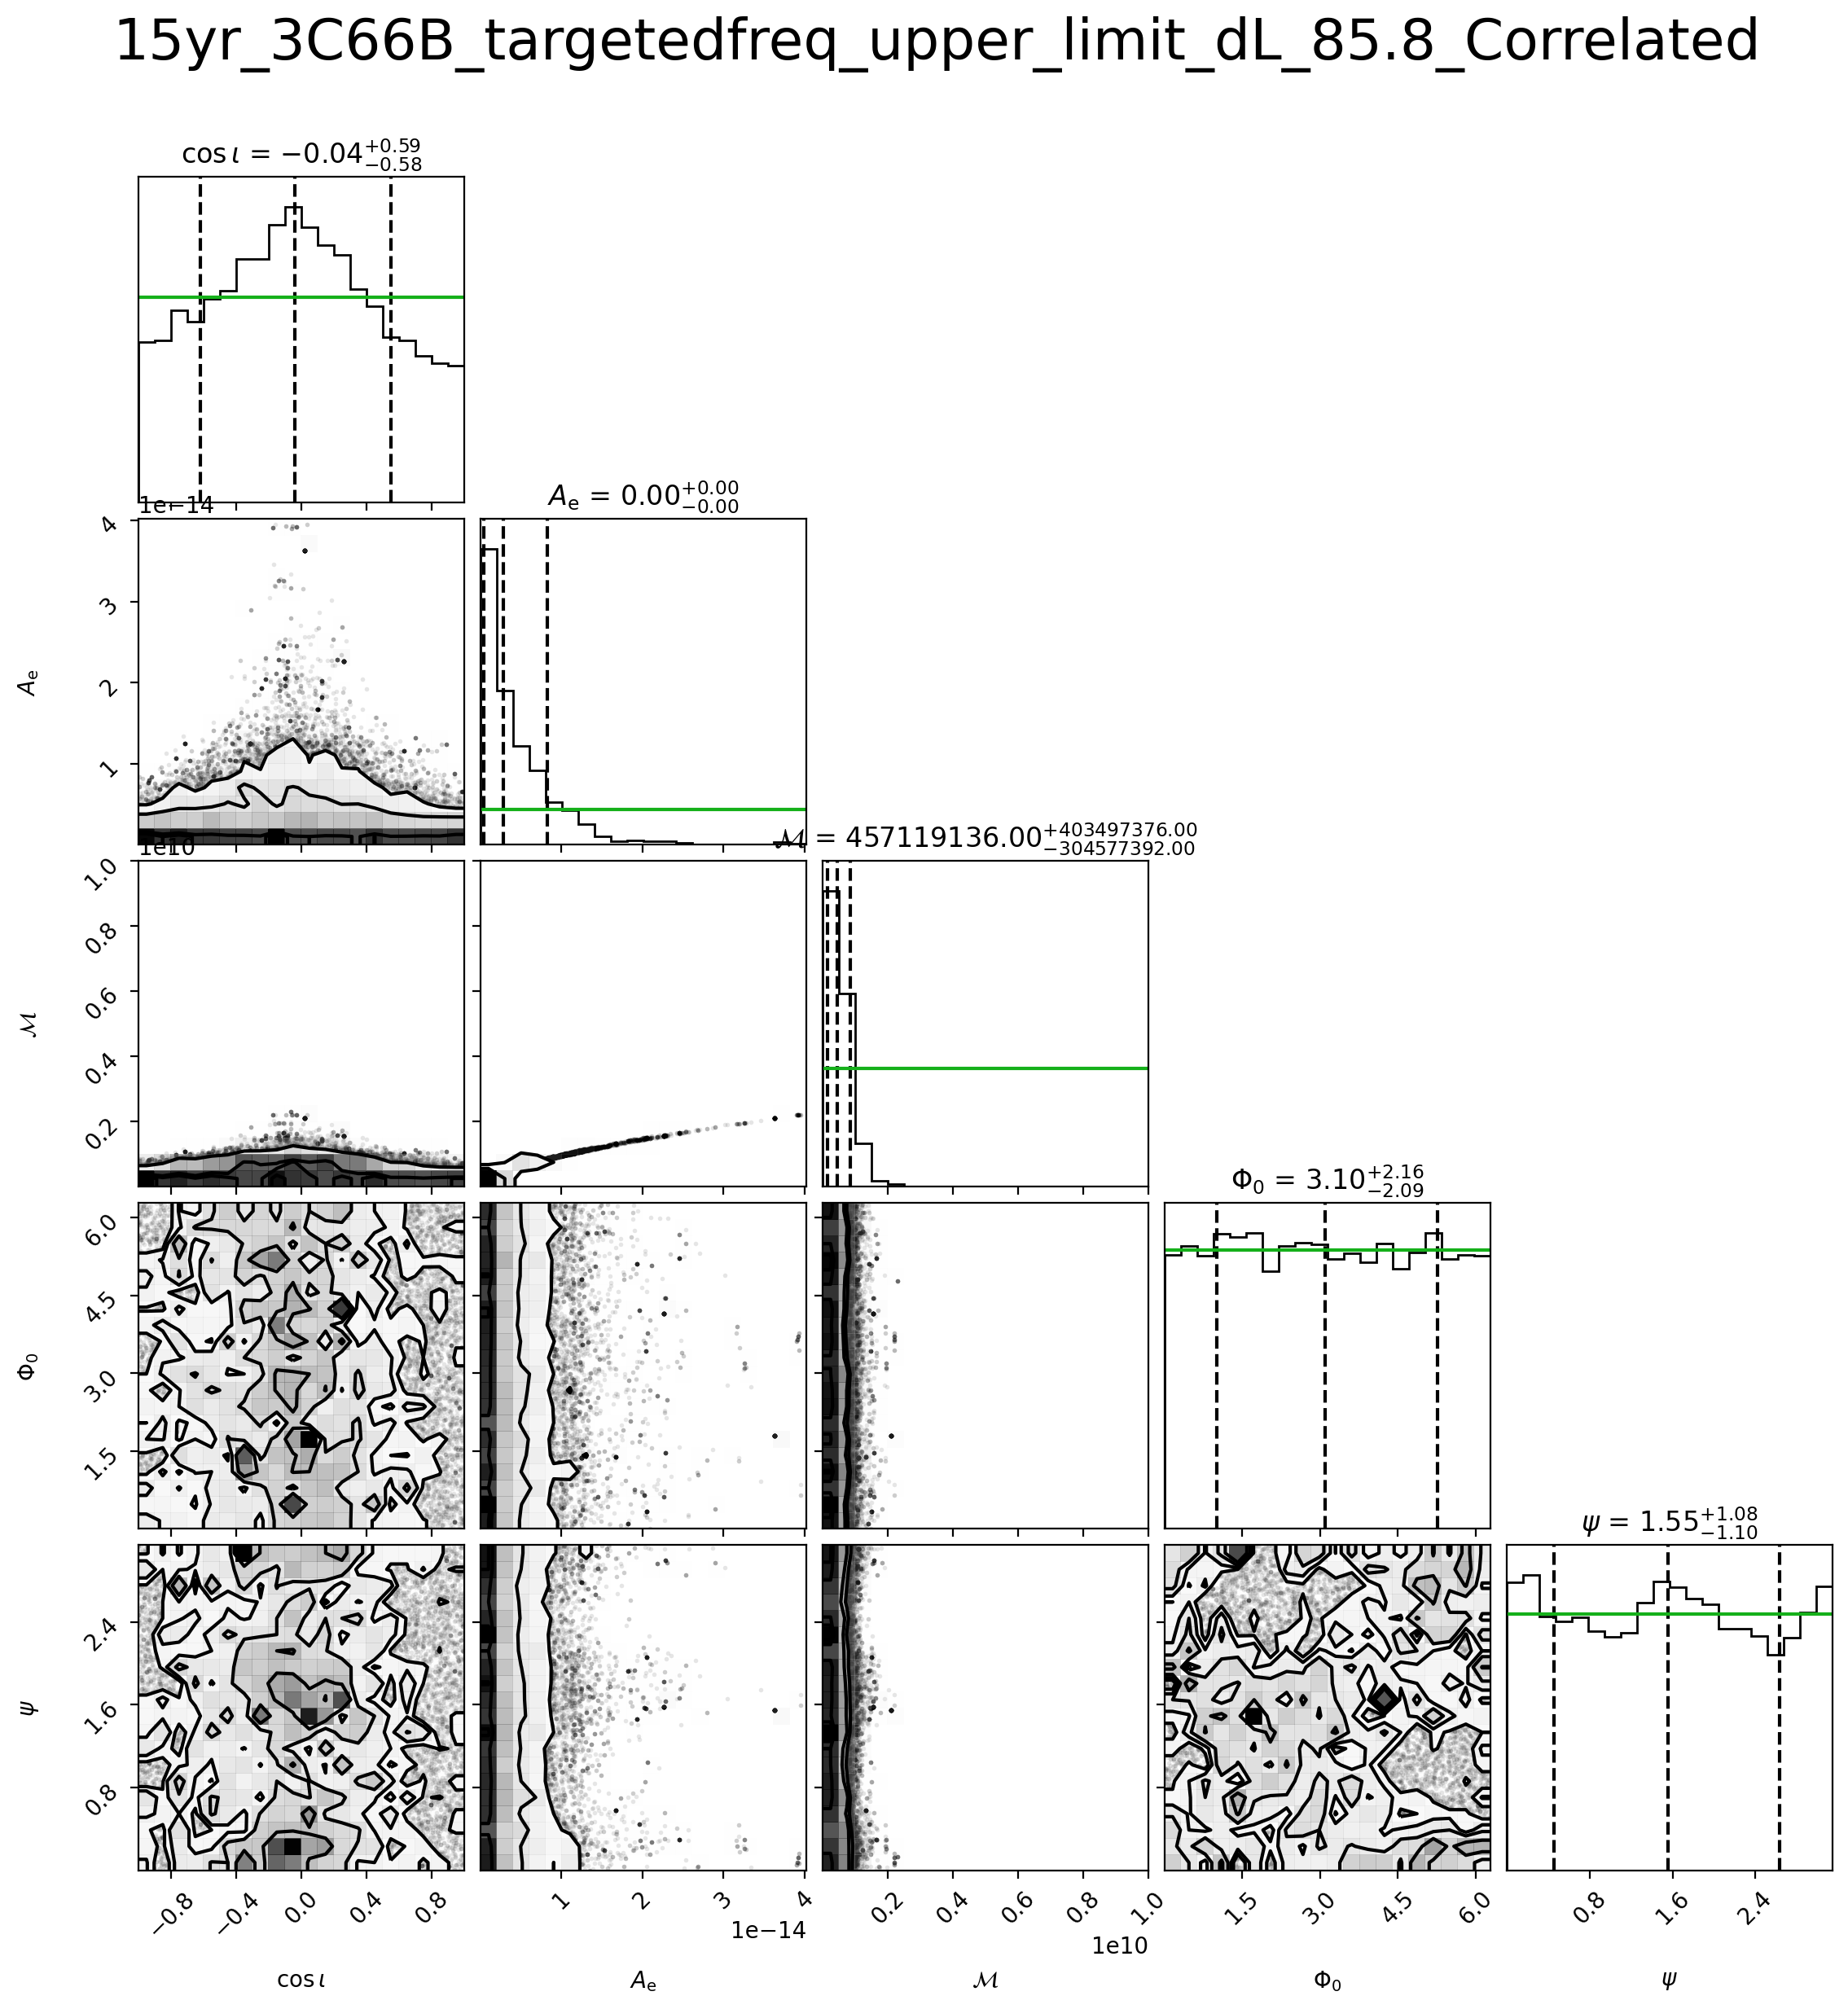

In [5]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$A_{\rm e}$", r"$\cal M$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (1.3175879e-18,4.0176795e-14), (10**6.6,10**10), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_UL = np.vstack((
                          samples2plot[d_L_mask,1],
                          np.power(10,(samples2plot[d_L_mask,4])),
                          10**samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7])).T


fig = corner.corner(samples2plot_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(10**-18, 10**-11)     #amplitude
        ax.plot(Xs,Xs*0+(1/(- 1.3102823e-18 + 4.2492482e-14)), color="xkcd:green")
        #ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(10**6.6, 10**10)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs,Xs*0+(1/((10**9.36) - (10**6.65))), color="xkcd:green")
        #ax.plot(Xs, 10**(Xs*0+1/3), color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_dL_85.8_Correlated', fontsize = 25,y=1.05);

## Trace Plots

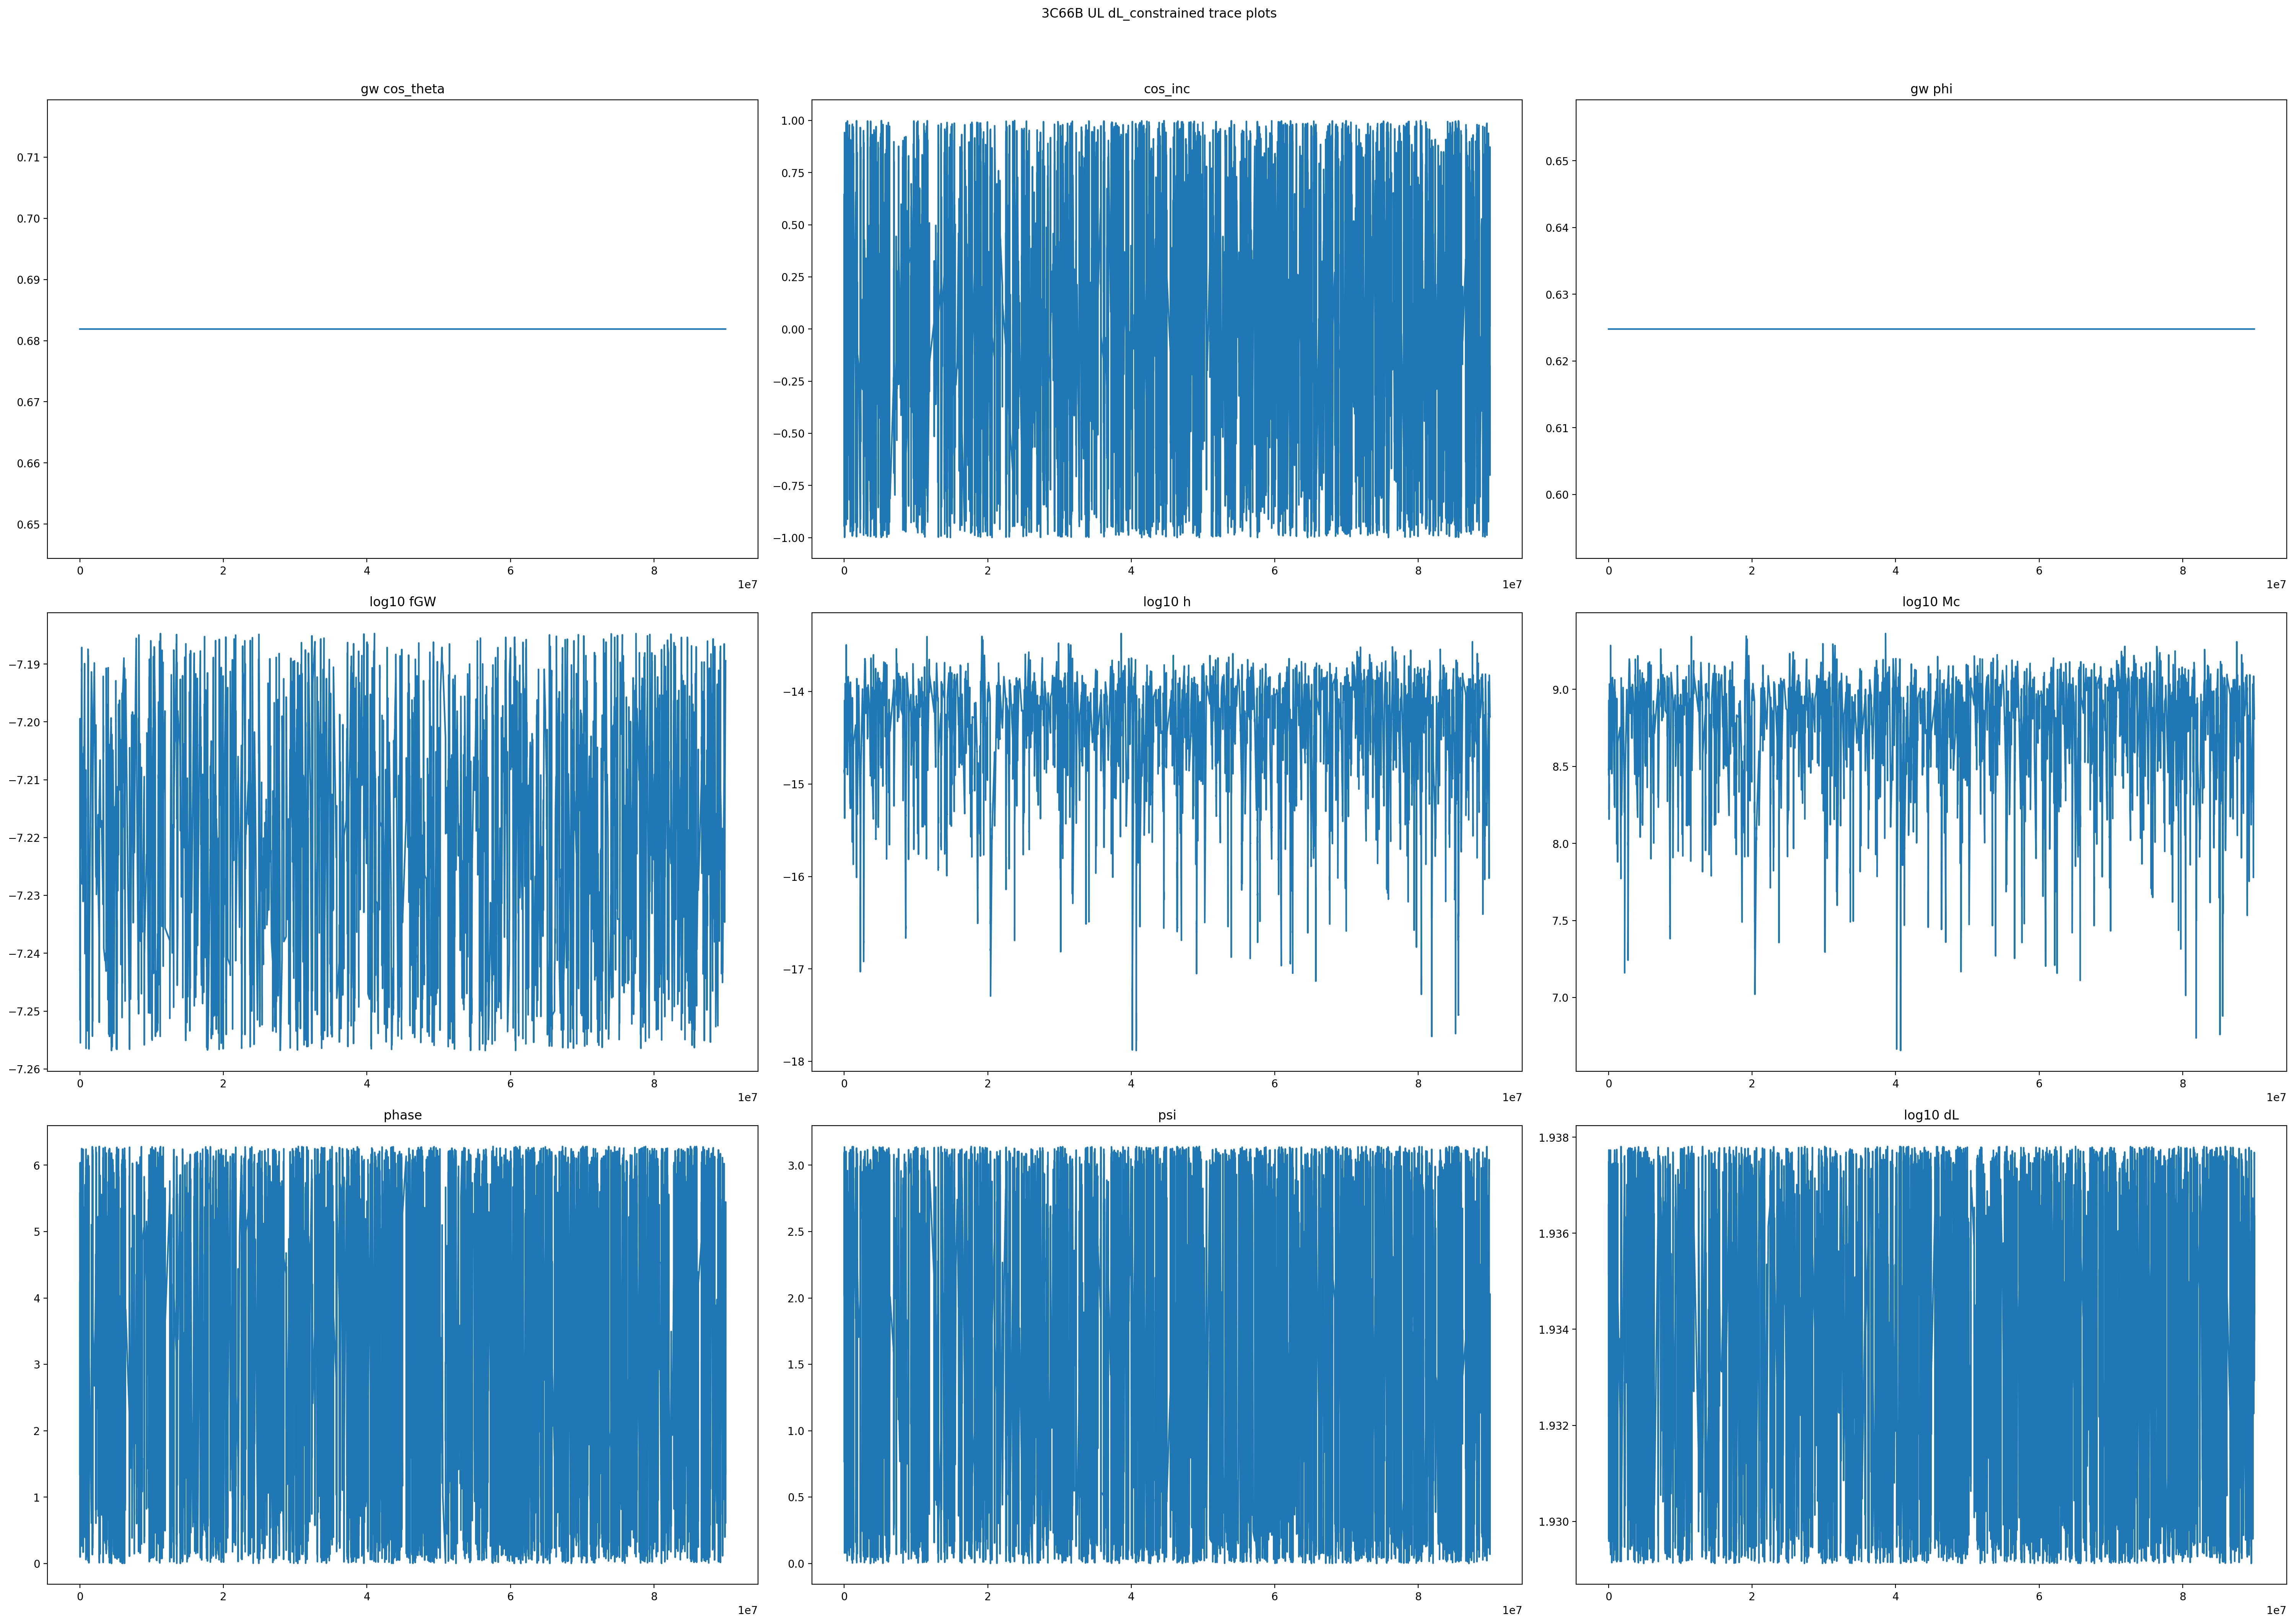

In [6]:
#TRACE PLOTS!!!!!!!

title = ["gw cos_theta", "cos_inc","gw phi","log10 fGW","log10 h","log10 Mc","phase","psi","log10 dL"]

j=-1
row = 3
column = 3
fig, axs = plt.subplots(row, column,figsize=(30,20))#, dpi=80,squeeze=False)
fig.tight_layout(h_pad=3,w_pad=2)
#axs = plt.gca()
for i in range(len(title)): 
    if i%3 == 0:
        j+=1
    #print(j,i)
    axs[j, i%3].plot(d_L_mask, samples2plot[d_L_mask,i])#, ls='', marker='.')
    #axs[j, i%4].ylabel("prior value")
    #axs[j, i%4].xlabel("samples")
    #axs[j, i%4].axhline(xxx[par], ls='--')
    axs[j, i%3].set_title(title[i])
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[1, i+1].plot(samples_cold[0][::,i+1], ls='', marker='.')

fig.suptitle('3C66B UL dL_constrained trace plots', y=1.05)
plt.subplots_adjust()

#display subplots 
#plt.show()
#plt.savefig("/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/NGC3115/detect/NGC3115_pulsar_trace_plots2.png",dpi='figure',bbox_inches="tight")
#print('done')


## 95 percentile Upper Limit (Generate strain histogram)

1.3102823e-18
4.2492482e-14
-17.882635
-13.371688
24967


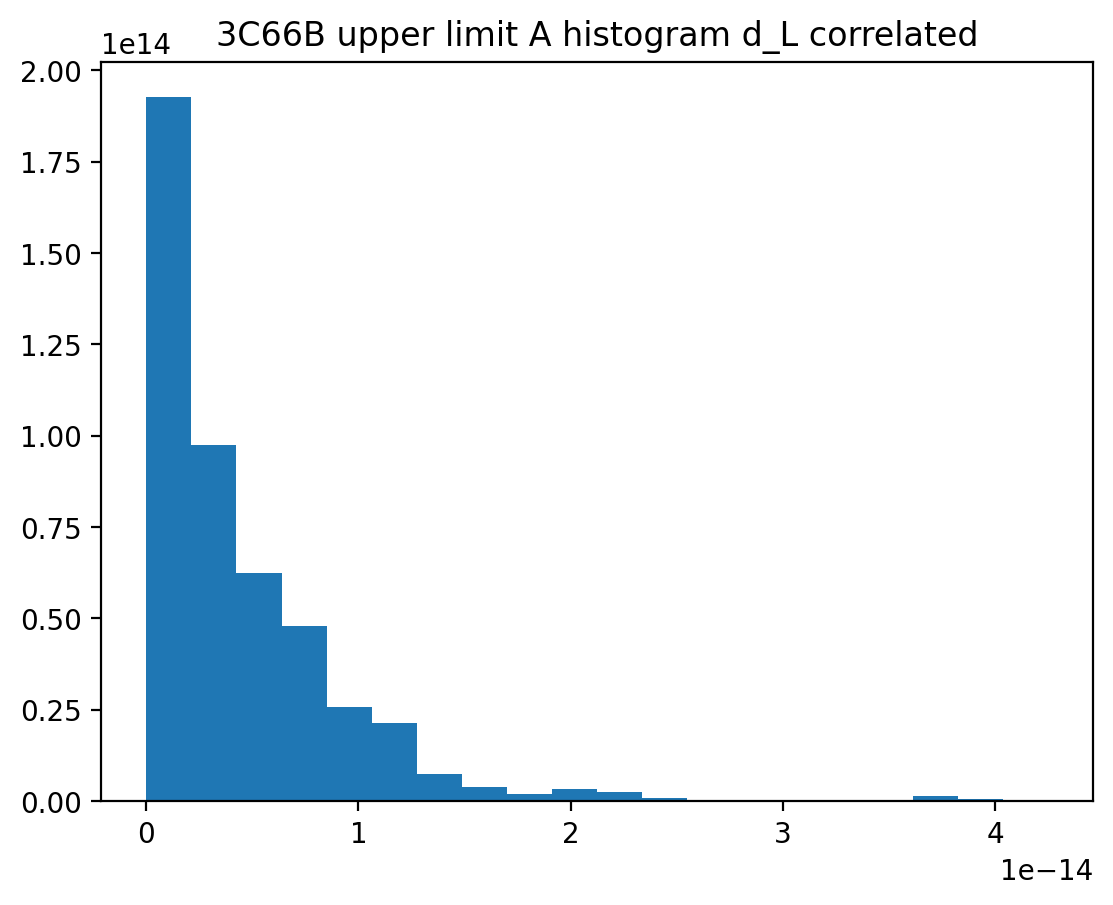

[1.3967194e-15 1.3920224e-15 1.3991414e-15 ... 5.3163502e-15 5.2981581e-15
 5.3460506e-15]
[3.0264742e+08 3.0264742e+08 3.0264742e+08 ... 6.4338189e+08 6.4338189e+08
 6.4338189e+08]


In [7]:
#To plot strain histogram and check min and max prior values for h and Mc

logAmin_dL = np.min(np.power(10,samples2plot[d_L_mask,4]))
logAmax_dL = np.max(np.power(10,samples2plot[d_L_mask,4]))
print(logAmin_dL)
print(logAmax_dL)
print(np.log10(logAmin_dL))
print(np.log10(logAmax_dL))
print(len(samples2plot[d_L_mask,4]))

plt.hist(np.power(10,samples2plot[d_L_mask,4]), bins=20, density=True)
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.title("3C66B upper limit A histogram d_L correlated")
plt.show()
print(np.power(10,samples2plot[d_L_mask,4]))
print(10**samples2plot[d_L_mask,5])

## 95 percentile Upper Limit (Generate Mc histogram)

6.656322
9.3623295
[8.480937 8.480937 8.480937 ... 8.808469 8.808469 8.808469]
[3.0264742e+08 3.0264742e+08 3.0264742e+08 ... 6.4338189e+08 6.4338189e+08
 6.4338189e+08]


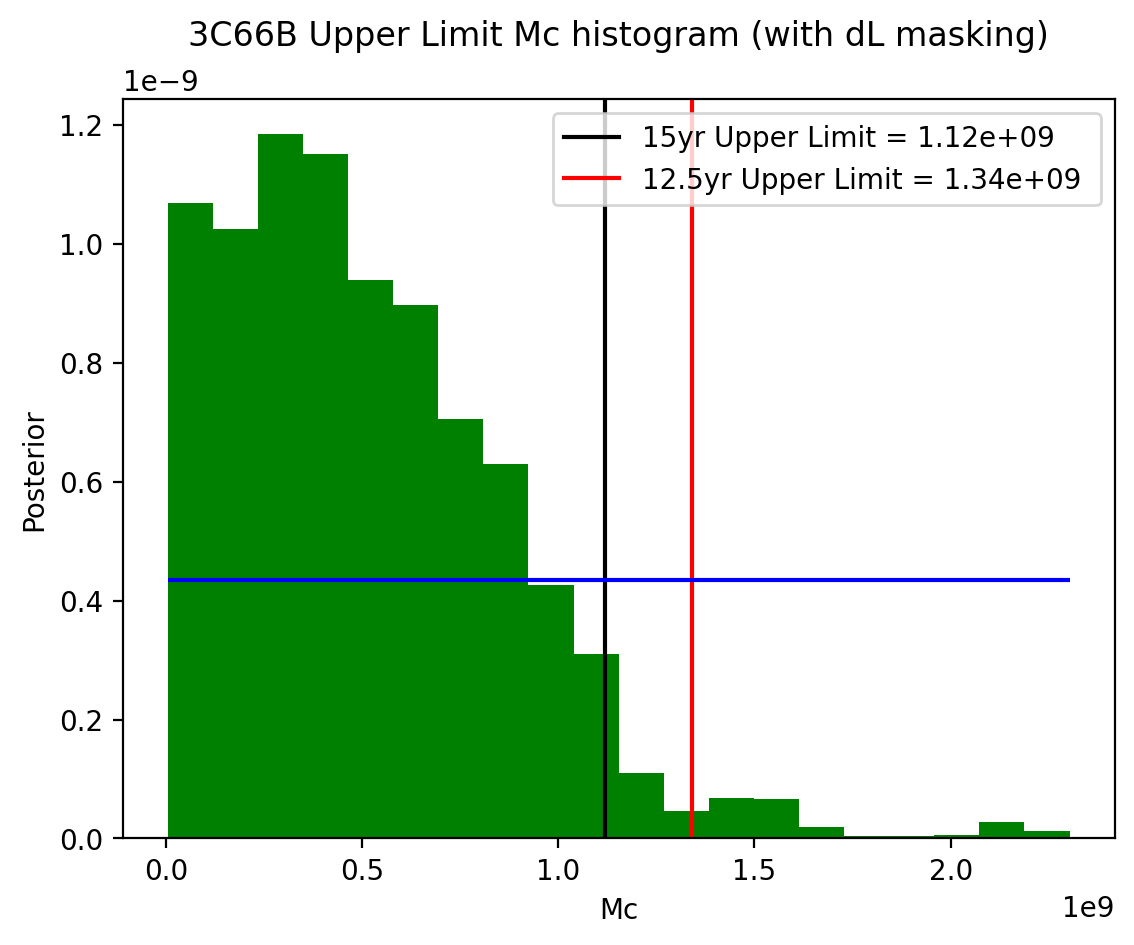

95% UL is 1120071680.0
9.049245816627627
values 4.350367906672719e-10


In [8]:
#dL Mc Upper limit

logMcmin_dL = np.min(samples2plot[d_L_mask,5])
logMcmax_dL = np.max(samples2plot[d_L_mask,5])

print(logMcmin_dL)
print(logMcmax_dL)
print(samples2plot[d_L_mask,5])
print(np.power(10,samples2plot[d_L_mask,5]))

plt.hist(np.power(10,samples2plot[d_L_mask,5]), bins=20, density=True,color='green')
plt.axvline(x = 1120071680.0,color='black',label= "15yr Upper Limit = 1.12e+09")
plt.axvline(x = 1.34e+09,color='red',label= "12.5yr Upper Limit = 1.34e+09 ")
plt.hlines(1/((10**logMcmax_dL) - (10**logMcmin_dL)),10**logMcmin_dL,10**logMcmax_dL, color='blue')
plt.title("3C66B Upper Limit Mc histogram (with dL masking)",y=1.05)
plt.xlabel("Mc")
plt.ylabel("Posterior")
plt.legend()
plt.show()

x = np.quantile(np.power(10,samples2plot[d_L_mask,5]), 0.95)
print("95% UL is",x)
print(np.log10(x))
print("values", 1/((10**logMcmax_dL) - (10**logMcmin_dL)))